<center><h1><b><u>PGExplainer with Custom BA2MOTIF Dataset</u></b></h1></center>

## __Importing Libraries, Classes, and Functions__

In [2]:
import torch
import torch_geometric
from torch_geometric.utils import to_dense_adj
from torch_geometric.utils import is_undirected, degree, to_networkx, from_networkx, to_dense_adj
import matplotlib.pyplot as plt

#BA2MOTIFS graph from scratch
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx #focuses on network analysis and graph theory; can create/visualize graphs
from tqdm import tqdm
import pickle
import random
from dataclasses import dataclass

#Classifier
import copy
import torch.nn as nn
from torch.nn import Linear, Sequential
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv, global_max_pool, global_mean_pool

#Importing PGExplainer
import os
import sys

#Other
import warnings
import random


In [3]:
device = torch.device('cpu')

### __Deserializing the Dataset__

In [4]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    ba2 = torch.load('../data/BA2MOTIF/custom-ba2.pt')

In [5]:
len(ba2)

1000

### __Loading Pretrained Model__

In [6]:
current_dir = os.getcwd()

src_dir = os.path.join(current_dir, '..', 'PGExplain/') #pathtocurrentdir/../PGExplain
sys.path.append(src_dir) #adds to list of strings that Python checks to import module; resets everytime you restart kernel

In [7]:
#Use altered GCN class that was added for compatibility; same model as in BA2MOTIF notebook
from ExplanationEvaluation.models.GCN import GCN

In [8]:
def load_model(filename):
    #model = GIN(num_features=1)
    model = GCN(input_dim=1, hidden_dim=32) #input dim is number of features for one node
    model.load_state_dict(torch.load(f'../models/BA2-Scratch/{filename}', weights_only=True))
    model.eval()
    model = model.to(device)
    return model

In [9]:
model_name = "GCN-100.00.pth"
model = load_model(model_name)

### __Example of Desired Subgraph to Identify__

In [10]:
def visualize_graph(data, index=0):
    G = to_networkx(data, to_undirected=True)

    # Create a dictionary mapping edges to their attributes
    edge_attr_dict = {(u.item(), v.item()): attr.item() for (u, v), attr in zip(data.edge_index.t(), data.edge_attr)}

    # Create the color list based on the edge attributes in the graph
    edge_colors = ['red' if edge_attr_dict.get(edge) == 1 else 'black' for edge in G.edges()]

    plt.figure(figsize=(8, 4))
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, edge_color=edge_colors, node_color='lightblue', with_labels=False, node_size=150, width = 3)
    plt.title(f"Graph {index} (Label: {data.y.item()})")
    plt.show()

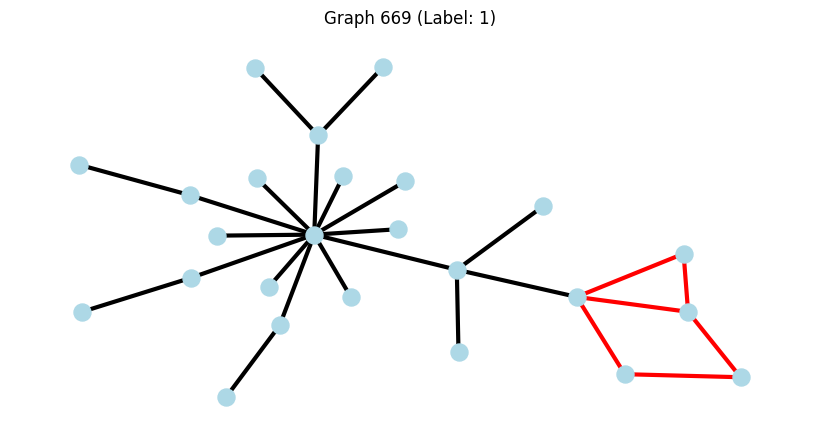

In [11]:
#This visualization is created through the ground truth edge labels
idx = random.randint(1, 1000)
visualize_graph(ba2[idx], idx)

## __Explaining the Model__

### __Loading the Dataset in Compatible Manner__

In [12]:
from ExplanationEvaluation.datasets.dataset_loaders import load_graph_dataset

#Load the dataset
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    graphs, features, labels, _, _, _ = load_graph_dataset() #graph are the edge indexes for each graph

#Make each of the lists into lists of tensors for compatability
features = torch.tensor(features) #each node has feature 1 (all the same)
labels = [torch.tensor(label) for label in labels] 
graphs = [graph.clone().detach() for graph in graphs]

### __Train PGExplainer__

In [13]:
from ExplanationEvaluation.explainers.PGExplainer import PGExplainer

In [71]:
num_epochs = 40
explainer = PGExplainer(model, graphs, features, task = "graph", epochs = num_epochs)

#Uses training process detailed in notes.pdf
indices = range(0, 800)

#Train the explainer
all_losses = explainer.prepare(indices)

Epoch 5 Total Loss: 2086.5786
Epoch 10 Total Loss: 2105.2727
Epoch 15 Total Loss: 1993.5638
Epoch 20 Total Loss: 1937.1595
Epoch 25 Total Loss: 1929.9557
Epoch 30 Total Loss: 1884.8390
Epoch 35 Total Loss: 1844.8130
Epoch 40 Total Loss: 1916.5836

Training completed.


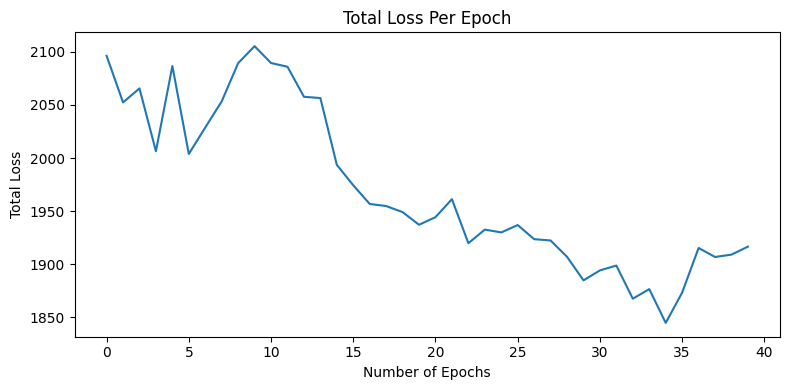

In [72]:
all_epochs = np.arange(0, num_epochs)
#1 row 2 columns, each ax object creates a plot (Axes object is not axis but a subplot)
fig, ax = plt.subplots(figsize=(8, 4))

#Avg loss
ax.set_title("Total Loss Per Epoch")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Total Loss")

ax.plot(all_epochs, all_losses)
plt.tight_layout()
plt.show()

In [22]:
#torch.save(explainer, '../models/PGExplainer/GCN-100.00-explainer.pt')

In [23]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    explainer = torch.load('../models/PGExplainer/GCN-100.00-explainer.pt')

### __Inference__

#### __Sampling Graph from Train or Test Data__

In [24]:
#graph_num = random.randint(0, 799) #train data
graph_num = random.randint(800, 999) #test data
#graph_num = random.randint(0, 999) #all data

edge_index, features, edge_importance_mask = explainer.explain(graph_num)
print(f"Explaning graph {graph_num}")

Explaning graph 900


##### __Feeding through GCN__

In [25]:
out = model(features, edge_index) #features, edge_index is attribute of one graph, ba2[idx]
pred = out.argmax(dim=1).item()

label = "House" if pred == 1 else "Cycle"
print(f"Classification of Motif: {label}")

Classification of Motif: Cycle


##### __Identifying the Explanatory Subgraph__

In [26]:
from ExplanationEvaluation.utils.plotting import highlight_explanation

num_top_edges = 16

highlight_edges, other_edges = highlight_explanation(edge_index, edge_importance_mask, num_top_edges)

In [27]:
def create_graph(edge_index):
    G = nx.Graph()
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i].item(), edge_index[1, i].item())
    return G

def draw_graph(G, pos, ax, title, highlight_edges=None, other_edges=None):
    nx.draw_networkx_nodes(G, pos, ax=ax, node_color='lightblue', node_size=200)
    
    #Graph 2
    if highlight_edges and other_edges:
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=highlight_edges, width=3, edge_color='red')
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=other_edges, width=3)
    
    #Graph 1
    else:
        nx.draw_networkx_edges(G, pos, ax=ax, width=3)
    
    ax.set_title(title)
    ax.axis('off')

def plot_graphs_side_by_side(edge_index, highlight_edges, other_edges):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    G = create_graph(edge_index)
    pos = nx.kamada_kawai_layout(G)
    
    # Graph 1 - Original Graph
    draw_graph(G, pos, ax1, "Original Graph")
    
    # Graph 2 - Highlighting Explainer Subgraph for GCN Classification
    draw_graph(G, pos, ax2, "Highlighted Explanatory Subgraph for GCN Classification", highlight_edges, other_edges)
    
    plt.tight_layout()
    return fig, (ax1, ax2)

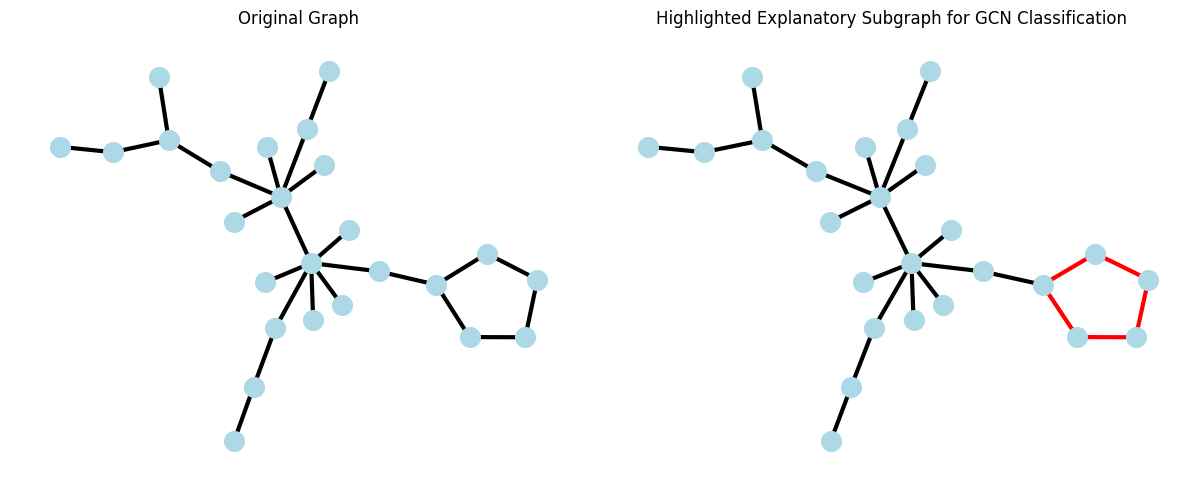

In [28]:
fig, (ax1, ax2) = plot_graphs_side_by_side(edge_index, highlight_edges, other_edges)
plt.show() #renders the figures

In [29]:
print("Edge Weights:\n")

for index, weight in enumerate(edge_importance_mask, start = 1): #start at 1 so 1st weight doesn't have own line
    print(f"{weight.item():.5f}", end=" ")
    if index % 17 == 0:
        print()  #newline after every 17 weights

Edge Weights:

0.69169 0.15764 0.69169 0.96204 0.69169 0.96822 0.15574 0.29818 0.96259 0.68454 0.68454 0.68454 0.98310 0.68454 0.15574 0.13788 0.90772 
0.09084 0.94413 0.98911 0.99886 0.99060 0.10777 0.15574 0.10777 0.10777 0.99610 0.99933 0.16276 0.94394 0.99952 0.10288 0.95836 0.99995 
0.99836 0.99963 0.98688 0.10777 0.99944 0.99993 0.99993 0.99552 0.99989 0.99999 1.00000 1.00000 1.00000 1.00000 0.99989 0.99999 